In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd

import argparse
import sys, os
import sklearn
import datetime

import importlib
from tqdm import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn_rvm import EMRVR
from sklearn.svm import SVR

from sklearn.neural_network import MLPRegressor
pd.set_option('display.max_columns', None)

In [2]:
# define this function to evaluate other models
def evaluate_clf(clf, X, y, train_index, test_index, include_indices=False):
    print(f'Training with {len(train_index)} samples; Testing with {len(test_index)} samples')
    
    # Get Train/Test Sets
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    # Train Model on Selected Fold
    clf.fit(X_train, y_train)
    y_pred = np.clip(clf.predict(X_test), 0, 1)
    
    # Organize and Return Results
    result = dict(
        instance = clf,
        X_train=X_train,
        X_test=X_test,
        y_train = y_train,        
        y_true = y_test,
        y_pred = y_pred,
        acc = clf.score(X_test, y_test),
        mae = mean_absolute_error(y_test, y_pred),
        rmse = mean_squared_error(y_test, y_pred, squared=False),
        rmsle = mean_squared_log_error(y_test, y_pred, squared=False),
    )
        
    if include_indices:
        result.update({
            'train_indices':train_index,
            'test_indices':test_index
        })
        
    return result

In [3]:
X = pd.read_pickle('Final\\X_df.pkl')

In [4]:
X

,dist_euclid,own_speed,target_speed,own_course,target_course
0,10.655910,9.827940,1.206454,109.262214,167.395637
1,3.116042,9.827940,38.151892,109.262214,7.500070
2,10.655910,1.206454,9.827940,167.395637,109.262214
3,10.479444,1.206454,38.151892,167.395637,7.500070
4,3.116042,38.151892,9.827940,7.500070,109.262214
...,...,...,...,...,...
264765,6.178706,1.657704,2.129840,188.961942,219.598516
264766,6.182760,2.129840,1.521905,219.598516,30.599527
264767,6.182760,1.521905,2.129840,30.599527,219.598516
264768,25.225222,1.251172,11.578077,218.256384,100.759199


In [5]:
y = pd.read_pickle('Final\\y_consequence_df.pkl')

In [6]:
y

,Consequence
0,0.233781
1,0.213215
2,0.233781
3,0.214537
4,0.157967
...,...
264765,0.302878
264766,0.156704
264767,0.176238
264768,0.222910


Text(0.5, 0, 'ves_cri')

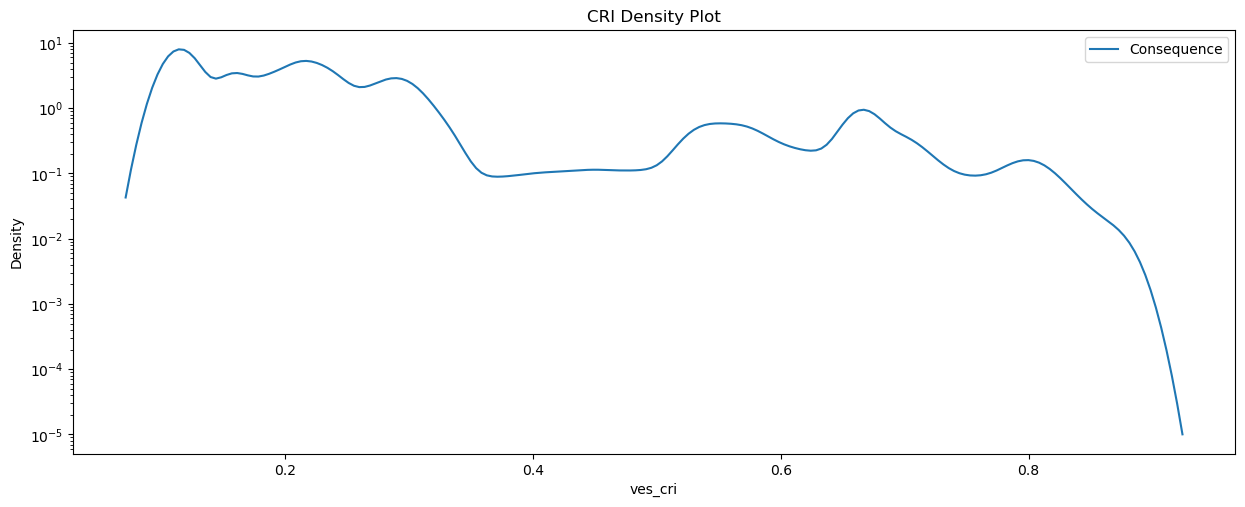

In [7]:
# Density vs consequence (final cri) plot in log scale
fig, ax = plt.subplots(1, figsize=(15, 5.5))

sns.kdeplot(data=y, ax=ax)
ax.set_yscale('log')
ax.set_title('CRI Density Plot')
ax.set_xlabel('ves_cri')

In [8]:
y_range = pd.cut(y['Consequence'], bins=np.arange(0, 1.1, .2), right=True, include_lowest=True)

(-0.001, 0.2]    124097

(0.2, 0.4]       107799

(0.4, 0.6]        14467

(0.6, 0.8]        17013

(0.8, 1.0]         1394

Name: Consequence, dtype: int64


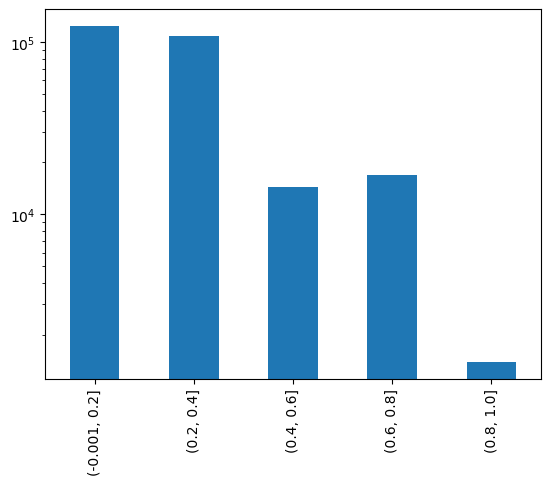

In [9]:
# bar graph to visualise consequence distribution in log scale
ves_cri_bin_val_counts = y_range.value_counts(sort=False)
print(ves_cri_bin_val_counts)
ax = ves_cri_bin_val_counts.plot.bar()
ax.set_yscale('log')
plt.savefig('y_range.pdf', dpi=300)

In [10]:
y_range = y_range.astype('str')

In [11]:
X_sub, _, y_sub, _, y_bin_sub, _ = train_test_split(X, y, y_range, train_size=0.35, random_state=10, stratify=y_range)

In [12]:
print(f"X_sub: {X_sub.shape}")
print(f"y_sub: {y_sub.shape}")
print(f"y_bin_sub: {y_bin_sub.shape}")

X_sub: (92669, 5)

y_sub: (92669, 1)

y_bin_sub: (92669,)


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

SVM-VCRA (Gang et al.)

In [14]:
# evaluating the performance of svm
clf = make_pipeline(StandardScaler(), SVR(gamma='auto', kernel='rbf', verbose=True))

svm_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    clf, X_sub, y_sub, train_index, test_index
) for (train_index, test_index) in tqdm(skf.split(X_sub, y_bin_sub), total=skf.get_n_splits(X_sub, y_bin_sub)))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


In [15]:
svm_vcra_skf_results_df = pd.DataFrame(svm_vcra_skf_results)
svm_vcra_skf_results_df

,instance,X_train,X_test,y_train,y_true,y_pred,acc,mae,rmse,rmsle
0,"(StandardScaler(), SVR(gamma='auto', verbose=T...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[2.5111773320904556, 9.253372206165157, 2.203...","[[0.1146001870060352], [0.6801402470121813], [...","[[0.11954646850877715], [0.2132153172200814], ...","[0.21937936082665993, 0.20247596584124983, 0.2...",0.185495,0.097987,0.142840,0.104296
1,"(StandardScaler(), SVR(gamma='auto', verbose=T...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[1.253491626733538, 2.7591395200603657, 12.68...","[[0.1146001870060352], [0.11954646850877715], ...","[[0.6801402470121813], [0.3115065561060313], [...","[0.27459715542490293, 0.2948878708547772, 0.22...",0.196195,0.097467,0.142150,0.103738
2,"(StandardScaler(), SVR(gamma='auto', verbose=T...","[[2.5111773320904556, 9.253372206165157, 2.203...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[0.11954646850877715], [0.6801402470121813], ...","[[0.1146001870060352], [0.2132153172200814], [...","[0.4972746325226745, 0.20201356445337149, 0.22...",0.186092,0.098219,0.142989,0.104509
3,"(StandardScaler(), SVR(gamma='auto', verbose=T...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[18.59116248533094, 32.14454927552727, 14.077...","[[0.1146001870060352], [0.11954646850877715], ...","[[0.2897443312554563], [0.15796744511169059], ...","[0.17719259808188043, 0.22569489636098927, 0.2...",0.184443,0.097996,0.142702,0.104471
4,"(StandardScaler(), SVR(gamma='auto', verbose=T...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[7.87503156391429, 8.971425913549384, 15.5274...","[[0.1146001870060352], [0.11954646850877715], ...","[[0.21199941718816054], [0.22589357018788817],...","[0.27882999611043446, 0.3363503497094738, 0.22...",0.184593,0.097843,0.142525,0.104353


In [16]:
svm_vcra_skf_results_df.to_pickle('svm_vcra_skf_results_v14.pickle')

CART-VCRA (Li et al.)


In [17]:
# evaluating the performance of random forest regressor
clf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=10, verbose=True))
    
cart_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    clf, X_sub, y_sub, train_index, test_index
) for (train_index, test_index) in tqdm(skf.split(X_sub, y_bin_sub), total=skf.get_n_splits(X_sub, y_bin_sub)))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.74it/s]


In [18]:
cart_vcra_skf_results_df = pd.DataFrame(cart_vcra_skf_results)
cart_vcra_skf_results_df

,instance,X_train,X_test,y_train,y_true,y_pred,acc,mae,rmse,rmsle
0,"(StandardScaler(), (DecisionTreeRegressor(max_...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[2.5111773320904556, 9.253372206165157, 2.203...","[[0.1146001870060352], [0.6801402470121813], [...","[[0.11954646850877715], [0.2132153172200814], ...","[0.17185152448935073, 0.145710539192281, 0.171...",0.386999,0.080476,0.123918,0.090987
1,"(StandardScaler(), (DecisionTreeRegressor(max_...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[1.253491626733538, 2.7591395200603657, 12.68...","[[0.1146001870060352], [0.11954646850877715], ...","[[0.6801402470121813], [0.3115065561060313], [...","[0.41617445931302866, 0.4743662512063983, 0.20...",0.373280,0.081822,0.125519,0.092178
2,"(StandardScaler(), (DecisionTreeRegressor(max_...","[[2.5111773320904556, 9.253372206165157, 2.203...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[0.11954646850877715], [0.6801402470121813], ...","[[0.1146001870060352], [0.2132153172200814], [...","[0.4268386363356404, 0.2012552807837801, 0.231...",0.374515,0.081160,0.125349,0.092141
3,"(StandardScaler(), (DecisionTreeRegressor(max_...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[18.59116248533094, 32.14454927552727, 14.077...","[[0.1146001870060352], [0.11954646850877715], ...","[[0.2897443312554563], [0.15796744511169059], ...","[0.18491119818718407, 0.16406307831166547, 0.1...",0.370840,0.081193,0.125339,0.092213
4,"(StandardScaler(), (DecisionTreeRegressor(max_...","[[0.1591550174144637, 4.845008859214445, 4.983...","[[7.87503156391429, 8.971425913549384, 15.5274...","[[0.1146001870060352], [0.11954646850877715], ...","[[0.21199941718816054], [0.22589357018788817],...","[0.26501403804683543, 0.3473842439647765, 0.21...",0.367693,0.080975,0.125507,0.092299


In [19]:
cart_vcra_skf_results_df.to_pickle('cart_vcra_skf_results_v14.pickle')

MLP-VCRA (Andrea et al.)

In [20]:
# evaluating the performance of MLP regressor
regr = make_pipeline(
        StandardScaler(), 
        MLPRegressor(random_state=10, max_iter=300, hidden_layer_sizes=(256, 32), 
                    verbose=True, early_stopping=True, n_iter_no_change=7)
    )

In [21]:
mlp_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
        regr, X_sub, y_sub, train_index, test_index
    ) for (train_index, test_index) in tqdm(skf.split(X_sub, y_bin_sub), total=skf.get_n_splits(X_sub, y_bin_sub)))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.83it/s]


In [22]:
mlp_vcra_results_df = pd.DataFrame(mlp_vcra_skf_results)
mlp_vcra_results_df.to_pickle('mlp_vcra_skf_results_v14.pickle')

Combining Results to a Unified DataFrame

In [23]:
cart_vcra_skf_results_df = pd.read_pickle('cart_vcra_skf_results_v14.pickle')
svm_vcra_skf_results_df = pd.read_pickle('svm_vcra_skf_results_v14.pickle')
mlp_vcra_skf_results_df = pd.read_pickle('mlp_vcra_skf_results_v14.pickle')

In [24]:
skf_results_df = pd.concat({
    'cart_vcra': cart_vcra_skf_results_df, 
    'svm_vcra': svm_vcra_skf_results_df,
    'mlp_vcra': mlp_vcra_skf_results_df
}, names=['model'])

In [25]:
skf_results_df.loc[:, 'r2_score'] = skf_results_df.apply(lambda l: sklearn.metrics.r2_score(l.y_true, l.y_pred), axis=1)
skf_results_df.groupby(level=0, sort=False).mean(numeric_only=True)

,acc,mae,rmse,rmsle,r2_score
model,,,,,
cart_vcra,0.374666,0.081125,0.125126,0.091964,0.374666
svm_vcra,0.187364,0.097902,0.142641,0.104273,0.187364
mlp_vcra,0.251924,0.092783,0.136857,0.100828,0.251924


In [26]:
skf_results_df.to_pickle('vcra_skf_results_df_v14.pickle')

Full Model

Li et al.

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
cart_vcra_lietal = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=10, verbose=True))
    
cart_vcra_skf_results = Parallel(n_jobs=-1)(delayed((evaluate_clf))(
    cart_vcra_lietal, X, y, train_index, test_index, include_indices=True
) for (train_index, test_index) in tqdm(skf.split(X, y_range), total=skf.get_n_splits(X, y_range)))

cart_vcra_skf_results_df = pd.DataFrame(cart_vcra_skf_results)
cart_vcra_skf_results_df
cart_vcra_skf_results_df.to_pickle('cart_vcra_skf_results_v14.trained_on_all_data.pickle')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.78it/s]


VCRA/F

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
mlp_vcra_ours = make_pipeline(
    StandardScaler(), 
    MLPRegressor(random_state=10, max_iter=100, hidden_layer_sizes=(256, 32), 
                 verbose=True, early_stopping=True, n_iter_no_change=10)
)

mlp_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    mlp_vcra_ours, X, y, train_index, test_index, include_indices=True
) for (train_index, test_index) in tqdm(skf.split(X, y_range), total=skf.get_n_splits(X, y_range)))

mlp_vcra_skf_results_df = pd.DataFrame(mlp_vcra_skf_results)
mlp_vcra_skf_results_df
mlp_vcra_skf_results_df.to_pickle('mlp_vcra_skf_results_v14.trained_on_all_data.pickle')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.61it/s]


Combining Results to a Unified DataFrame

In [36]:
cart_vcra_skf_results_df = pd.read_pickle('cart_vcra_skf_results_v14.trained_on_all_data.pickle')
mlp_vcra_skf_results_df = pd.read_pickle('mlp_vcra_skf_results_v14.trained_on_all_data.pickle')

skf_results_df = pd.concat({
    'cart_vcra': cart_vcra_skf_results_df, 
    'mlp_vcra': mlp_vcra_skf_results_df
}, names=['model'])
skf_results_df.loc[:, 'r2_score'] = skf_results_df.apply(lambda l: sklearn.metrics.r2_score(l.y_true, l.y_pred), axis=1)
skf_results_df.to_pickle('vcra_skf_results_df.cart_vs_mlp.trained_on_all_data.pickle')
 
skf_results_df.groupby(level=0).mean(numeric_only=True)

,acc,mae,rmse,rmsle,r2_score
model,,,,,
cart_vcra,0.467680,0.072194,0.115434,0.084784,0.467680
mlp_vcra,0.291686,0.089821,0.133156,0.098153,0.291686


In [37]:
skf_results_df

instance  \
model                                                            
cart_vcra 0  (StandardScaler(), (DecisionTreeRegressor(max_...   
          1  (StandardScaler(), (DecisionTreeRegressor(max_...   
          2  (StandardScaler(), (DecisionTreeRegressor(max_...   
          3  (StandardScaler(), (DecisionTreeRegressor(max_...   
          4  (StandardScaler(), (DecisionTreeRegressor(max_...   
mlp_vcra  0  (StandardScaler(), MLPRegressor(early_stopping...   
          1  (StandardScaler(), MLPRegressor(early_stopping...   
          2  (StandardScaler(), MLPRegressor(early_stopping...   
          3  (StandardScaler(), MLPRegressor(early_stopping...   
          4  (StandardScaler(), MLPRegressor(early_stopping...   

                                                       X_train  \
model                                                            
cart_vcra 0  [[10.655909742429152, 9.82793975857709, 1.2064...   
          1  [[3.1160421413692085, 9.82793975857709, 38.151...   
          2  [[10.655909742429152, 9.82793975857709, 1.2064...   
          3  [[10.655909742429152, 9.82793975857709, 1.2064...   
          4  [[10.655909742429152, 9.82793975857709, 1.2064...   
mlp_vcra  0  [[10.655909742429152, 9.82793975857709, 1.2064...   
          1  [[3.1160421413692085, 9.82793975857709, 38.151...   
          2  [[10.655909742429152, 9.82793975857709, 1.2064...   
          3  [[10.655909742429152, 9.82793975857709, 1.2064...   
          4  [[10.655909742429152, 9.82793975857709, 1.2064...   

                                                        X_test  \
model                                                            
cart_vcra 0  [[10.479443674801505, 1.206453993782595, 38.15...   
          1  [[10.655909742429152, 9.82793975857709, 1.2064...   
          2  [[3.1160421413692085, 38.15189189066979, 9.827...   
          3  [[20.096848889157272, 1.8709874490746883, 12.1...   
          4  [[3.1160421413692085, 9.82793975857709, 38.151...   
mlp_vcra  0  [[10.479443674801505, 1.206453993782595, 38.15...   
          1  [[10.655909742429152, 9.82793975857709, 1.2064...   
          2  [[3.1160421413692085, 38.15189189066979, 9.827...   
          3  [[20.096848889157272, 1.8709874490746883, 12.1...   
          4  [[3.1160421413692085, 9.82793975857709, 38.151...   

                                                       y_train  \
model                                                            
cart_vcra 0  [[0.2337809092831982], [0.2132153172200814], [...   
          1  [[0.2132153172200814], [0.2337809092831982], [...   
          2  [[0.2337809092831982], [0.2132153172200814], [...   
          3  [[0.2337809092831982], [0.2132153172200814], [...   
          4  [[0.2337809092831982], [0.21453676665884835], ...   
mlp_vcra  0  [[0.2337809092831982], [0.2132153172200814], [...   
          1  [[0.2132153172200814], [0.2337809092831982], [...   
          2  [[0.2337809092831982], [0.2132153172200814], [...   
          3  [[0.2337809092831982], [0.2132153172200814], [...   
          4  [[0.2337809092831982], [0.21453676665884835], ...   

                                                        y_true  \
model                                                            
cart_vcra 0  [[0.21453676665884835], [0.2132153172200814], ...   
          1  [[0.2337809092831982], [0.15796744511169059], ...   
          2  [[0.15796744511169059], [0.18444344971343127],...   
          3  [[0.4016543756813015], [0.2132153172200814], [...   
          4  [[0.2132153172200814], [0.2337809092831982], [...   
mlp_vcra  0  [[0.21453676665884835], [0.2132153172200814], ...   
          1  [[0.2337809092831982], [0.15796744511169059], ...   
          2  [[0.15796744511169059], [0.18444344971343127],...   
          3  [[0.4016543756813015], [0.2132153172200814], [...   
          4  [[0.2132153172200814], [0.2337809092831982], [...   

                                                        y_pred       acc  \
model        

In [38]:
bins=np.arange(0, 1.1, .2)

In [49]:
def metrics_per_cri_pct(sdf):
    # Ensure y_true is 1-dimensional
    y_true = sdf.y_true.flatten() if sdf.y_true.ndim > 1 else sdf.y_true
    buckets = pd.cut(y_true, bins, right=True, include_lowest=True)
    return pd.DataFrame({'y_true': y_true, 'y_pred': sdf.y_pred}).groupby(buckets).apply(
        lambda l: mean_squared_log_error(l.y_true, l.y_pred, squared=False)
    )

skf_results_df.apply(
    lambda l: metrics_per_cri_pct(l), 
    axis=1
).groupby(level=0).mean()

,"(-0.001, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
model,,,,,
cart_vcra,0.077982,0.045546,0.161662,0.172331,0.172483
mlp_vcra,0.089379,0.049079,0.196149,0.201172,0.194838


In [51]:
Out[49].columns = ['[0, 0.2]', '(0.2, 0.4]', '(0.4, 0.6]', '(0.6, 0.8]', '(0.8, 1.0]']
Out[49]

,"[0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
model,,,,,
cart_vcra,0.077982,0.045546,0.161662,0.172331,0.172483
mlp_vcra,0.089379,0.049079,0.196149,0.201172,0.194838
